## Jupyter notebook for manuscript titled: "Paleointensity Estimates from the Pleistocene of Northern Israel: Implications for hemispheric asymmetry in the time-averaged field"

Authors:  Tauxe, L, Asefaw, H., Behar, N., Koppers, A.A.P., and Shaar, R.

Abstract: 

Twenty-two sites, subjected to an IZZI-modified Thellier-Thellier experiment and strict selection criteria, recover a  paleomagnetic axial dipole moment (PADM) of 62.24$\pm$ 30.6 ZAm$^2$  in Northern Israel over the Pleistocene (0.012 - 2.58 Ma). Pleistocene data from  comparable studies from Antarctica, Iceland, and Hawaii,  re-analyzed 
using the same criteria and age range, show that the Northern Israeli data are on average   slightly higher than those from Iceland (PADM = 53.8 $\pm$ 23 ZAm$^2$, n = 51 sites) and  even higher than the  Antarctica average %\cite{asefaw21} 
(PADM = 40.3 $\pm$ 17.3 ZAm$^2$, n = 42 sites). Also, the  data from the Hawaiian drill core, HSDP2, spanning the last half million years (PADM = 76.7 $\pm$ 21.3 ZAm$^2$, n = 59 sites) are higher than those from Northern Israel.  These results, when compared to Pleistocene results filtered from the PINT database (www.pintdb.org) suggest that data from the Northern hemisphere mid-latitudes are on average higher than those from the southern hemisphere and than those from latitudes higher than 60$^{\circ}$N.
The weaker intensities found at high (northern and southern) latitudes therefore,  cannot be attributed to inadequate spatio-temporal sampling of a time-varying dipole moment or low quality data. The high fields in mid-latitude Northern hemisphere could result from long-lived non-axial dipole  terms in the geomagnetic field with episodes of high field intensities occurring at different times in different longitudes. This hypothesis is supported by an asymmetry predicted from  the Holocene, 100 kyr,  and five million year time-averaged geomagnetic field models. 

doi: 10.1002/essoar.10511070.1.   NB: preprint in ESSOAR.  change this when accepted


[Import code and set variables](#Import_code)

[Set up DataFrames for plotting](#Make_DataFrames)

[Code for making Figure 1](#Figure_1)

[Code for making Figure 2](#Figure_2)

[Notes on  Figure 3](#Figure_3)

[Notes on  Figure 4 ](#Figure_4)

[Code for making Figure 5](#Figure_5)

[Code for making Figure 6](#Figure_6)

[Code for making Figure 7](#Figure_7)

[Code for making Figure 8](#Figure_8)

[Code for making Figure 9](#Figure_9)

[Code for making Figure 10](#Figure_10)

[Code for making Figure S1](#Figure_S1)

## Import_code 
- import python modules
- import mapping functions
- import PmagPy modules
- set variables used in the notebook

In [1]:
# import useful python code
import pandas as pd
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os # import some operating system utilities
import zipfile as zf # import the zipfile module for unpacking zip files
import shutil as shutil # another useful module with system utilities
import requests, pandas, getpass
import string
import statistics as sstats

## mapping functions
import cartopy 
import cartopy.crs as ccrs
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy import feature as cfeature
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE, OCEAN, LAKES, BORDERS,RIVERS
import matplotlib.ticker as mticker
from matplotlib import cm

#import packages from PmagPy
import timescalePlotter as ts_plotter
import pmagpy.pmag as pmag # pmagpy functions to calculate paleomagnetic parameters
import pmagpy.ipmag as ipmag # pmagpy functions for use in notebooks
import pmagpy.pmagplotlib as pmagplotlib # pmagpy plotting functions
import pmagpy.coefficients as cf # geomagnetic field coefficients
# set api for interaction with MagIC database
api = 'https://api.earthref.org/v1/MagIC/{}'



# set variables for use in notebook

age_min,age_max=0.0118,2.58 # age range of Pleistocene
fontsize=14
markersize=7
from importlib import reload
    
text_font={'size':fontsize}
fig_dir='/Users/ltauxe/Dropbox/Apps/Overleaf/GolanHeights/Figures/'
averaging=True
cmap='jet'
minB=20
maxB=70




In [2]:
## helpful mapping functions
import shapely.geometry as sgeom
from copy import copy
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
    

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels


In [3]:
# function for plotting ArAr data from OSU lab
def get_arar(ax,file,site,age,age_unit):
    arar_dir='Koppers ArAr data/'
    
    sum_df=pd.read_excel(arar_dir+file,sheet_name='Age Summary',header=2)
    sum_df.dropna(subset=['38Ar\n[fA]','Relative\nAbundances'],inplace=True)
    sum_df=sum_df[['39Ar\n[fA]','Age', '± 2s.1']]
    sum_df.columns=['39Ar_frac','Age','2sigma']

    if age_unit=='ka':
        sum_df['Age']=sum_df['Age']*1e-3
        sum_df['2sigma']=sum_df['2sigma']*1e-3
    sum_df['cum_sum']=sum_df['39Ar_frac'].cumsum()
    sum_df['cum_perc']=100*sum_df['cum_sum']/sum_df['39Ar_frac'].sum()
    sum_df['ages_high']=sum_df['Age']+sum_df['2sigma']
    sum_df['ages_low']=sum_df['Age']-sum_df['2sigma']
    percs=sum_df['cum_perc'].values
    ages_high=sum_df['ages_high'].values
    ages_low=sum_df['ages_low'].values

    for k in range(0,len(percs)-2):

        xs=[percs[k],percs[k+1]]

        ymaxs=[ages_high[k],ages_high[k]]
        ymins=[ages_low[k],ages_low[k]]
        ax.plot(xs,ymaxs,'b-')
        ax.plot(xs,ymins,'b-')
        ax.plot([xs[1],xs[1]],[ages_high[k],ages_high[k+1]],'b-')
        ax.plot([xs[1],xs[1]],[ages_low[k],ages_low[k+1]],'b-')
    plt.text(.1,.9,site+': '+age + ' Ma',transform=ax.transAxes,fontsize=fontsize)
    ax.axhline(float(age),linestyle='dotted',color='black',linewidth=2)
    if ages_low.min()<-float(age):
        ymin=-float(age)-.2
    else:
        ymin=ages_low.min()-.4
    if ages_high.max()>10*float(age):
        ymax=10*float(age)
    else:
        ymax=ages_high.max()+.4

    ax.set_ylim(ymin,ymax)
    ax.set_xlim(0,100)
    return sum_df





## Make_DataFrames
- Download data  from MagIC associated with this paper.
- Unpack the data


In [4]:
dir_path='ghi_magic'
if True: # This will change upon acceptance of the manuscript
    contribution_id = 19491
    private_key = 'b161c048-ff5e-4981-a75b-99ee50a32fa5' # private key in MagIC

# verify that contribution has been validated
    shared_contribution_response = requests.get(api.format('data'), params={'id': contribution_id, 'key': private_key})
    if (shared_contribution_response.status_code == 200):
        shared_contribution_text = shared_contribution_response.text
        print(shared_contribution_text[0:200], '\n')
    elif (shared_contribution_response.status_code == 204): # bad file
        print('Contribution ID and/or private key do not match any contributions in MagIC.', '\n')
    else:
        print('Error:', shared_contribution_response.json()['err'][0]['message'], '\n')
     # save and unpack downloaded data  
    magic_contribution='magic_contribution_'+str(contribution_id)+'.txt'
    magic_out=open(dir_path+'/'+magic_contribution, 'w', errors="backslashreplace")
    magic_out.write(shared_contribution_text)
    ipmag.download_magic(magic_contribution,dir_path=dir_path,print_progress=False) # unpack the file

tab delimited	contribution
id	version	timestamp	contributor	data_model_version	reference	lab_names
19491	1	2022-06-20T17:08:43.935Z	@ltauxe	3.0	10.1002/ESSOAR.10511070.1	Paleomagnetic Lab (Scripps Ins 

1  records written to file  /Users/ltauxe/Documents/writing_stuff/Notebook_GIT/Paper_notebooks/Pleistocene_paleointensity/ghi_magic/contribution.txt
4  records written to file  /Users/ltauxe/Documents/writing_stuff/Notebook_GIT/Paper_notebooks/Pleistocene_paleointensity/ghi_magic/locations.txt
206  records written to file  /Users/ltauxe/Documents/writing_stuff/Notebook_GIT/Paper_notebooks/Pleistocene_paleointensity/ghi_magic/sites.txt
103  records written to file  /Users/ltauxe/Documents/writing_stuff/Notebook_GIT/Paper_notebooks/Pleistocene_paleointensity/ghi_magic/samples.txt
617  records written to file  /Users/ltauxe/Documents/writing_stuff/Notebook_GIT/Paper_notebooks/Pleistocene_paleointensity/ghi_magic/specimens.txt
15587  records written to file  /Users/ltauxe/Documents/writing_

- set up DataFrames for each study re-analyzed here
- unpack and filter data downloaded from the PINT database
- read in the data from PADM2M (Ziegler et al., 2011)

In [5]:
# read in the MagIC site level datafile
df=pd.read_csv(dir_path+'/sites.txt',sep='\t',header=1)
gh_site_df=df[df['location'].str.contains('Golan Heights')]
df.dropna(subset=['int_abs'],inplace=True) # use only sites with intensity data

df['vadm_ZAm2']=np.round(df['vadm'].astype('float').values*1e-21,1) #convert Am2 to ZAm2
df['vadm_ZAm2_sigma']=df['vadm_sigma']*1e-21
df['int_uT']=df['int_abs']*1e6 # convert tesla to uT
gh_df=df[df['location'].str.contains('Golan Heights')]
ant_df=df[df['location'].str.contains('McMurdo')]
ice_df=df[df['location'].str.contains('Iceland')]
haw_df=df[df['location'].str.contains('HSDP2')]
# read in PADM2M (Ziegler et al., 2011) and clean up
padm2m=pd.read_csv('padm2m.pf',skiprows=1,header=None)
padm2m.columns=['vadm'] # VADM in  10^22 Am2
padm2m['vadm_ZAm2']=padm2m['vadm']*10 # 10^22 Am2 => ZAm2
ages=np.arange(0,2.002,.001)
padm2m['age']=ages




- read in data downloaded from the PINT database
- filter for 'quality'
- replace studies re-analyzed in this study

In [6]:
# read in and filter PINT data downloaded from the PINT database
pint_df=pd.read_csv('data_zam20220119110733.txt',sep='|',skiprows=4,header=0)
skip_refs=[' 639 ',' 663 ',' 707 ', ' 210 ',' 719 '] # exclude data re-analyzed in this paper
pint_df=pint_df[pint_df[' REF '].isin(skip_refs)==False]
# clean up the DataFrame
pint_df.dropna(subset=[' DB '],inplace=True)# drop data with nan DB (uncertainty) fields
pint_df=pint_df[pint_df[' DB ']!='  '] # drop data with blank DB  (uncertainty) fields
pint_df=pint_df[pint_df[' DAGE ']!='  '] # drop data with no age
pint_df['lat']=pint_df[' SLAT '].astype('float') # convert lat to float
pint_df['lon']=pint_df[' SLONG '].astype('float')# convert long to float
pint_df['int_uT']=pint_df[' B '].astype('float') # convert intensity (B) to float in microtesla
pint_df['int_abs_sigma']=1e-6*pint_df[' DB '].astype('float') # convert intensity uncertainty to tesla
pint_df['int_abs_uT_sigma']=pint_df[' DB '].astype('float')
pint_df['int_abs_sigma_perc']=pint_df[' DB% '].astype('float')# convert sigma % to float
pint_df['age']=pint_df[' AGE '].astype('float') # convert age to float
pint_df['age_sigma']=pint_df[' DAGE '].astype('float') # convert age uncertainty to float
pint_df=pint_df[pint_df['age']<=age_max] # filter for age to be Pleistocene 
pint_df=pint_df[pint_df['age_sigma']<=0.2] # filter for age uncertainties less than 0.2 Ma
# filter for same site level criteria as in CCRIT (sigma < 4uT OR sigma_% < 10)
pint_df=pint_df[(pint_df['int_abs_uT_sigma']<=4) | (pint_df['int_abs_sigma_perc']<=10)] 
pint_df['citations']=pint_df[' REF '] # use REF in MagIC 'citations' key
# calculate vadm and vadm_sigma using B and site latitude (for consistency)
pint_df['vadm']=pmag.b_vdm(1e-6*pint_df['int_uT'].values,pint_df['lat'].values)
# do same for vadm_sigma
pint_df['vadm_sigma']=pmag.b_vdm(1e-6*pint_df['int_abs_uT_sigma'].values,pint_df['lat'].values)

# convert to ZAm2 for consistency
pint_df['vadm_ZAm2']=pint_df['vadm']*1e-21
pint_df['vadm_ZAm2_sigma']=pint_df['vadm_sigma']*1e-21
pint_df=pint_df[['citations','lat','lon','age','age_sigma','vadm_ZAm2','vadm_ZAm2_sigma','int_uT']]
# add in the newly calculated data from this study to the PINT data set
new_pint=pd.concat([pint_df,gh_df,ant_df,ice_df,haw_df])



## Figure_1

This section makes the figures that were combined for Figure 1 in paper.  These were combined using Adobe Illustrator for the final version in the paper. 

Caption:

Intensity (in $\mu$T) of the geomagnetic field from global field models.  a) International Geomagnetic Reference Field (IGRF) for the year 2022 (Atkin et al, 2021). b) Average of the Holocene field from CALS10k.2 (Constable et al., 2016)}. c) Average field for the last 100 ka (Panovska et al., 2018). d) LN3 time averaged field model for the last 5 Ma (Cromwell et al, 2018).



### Present field (2021)

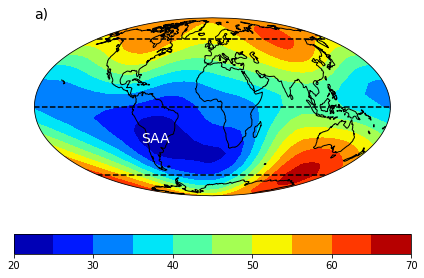

In [7]:
# code to make figure 1a

equator_lons=np.arange(-180,190,10)
equator_lats=np.zeros(len(equator_lons))
midS_lats=np.ones(len(equator_lons))*60
midN_lats=np.ones(len(equator_lons))*-60
date,mod,lon_0,alt,ghfile=2021,"",0,0,"" # only date is required
# get declination, inclination, intensity, radial intensity from the lats,lons
# returned by pmagplotlib.plot_mag_map using the IGRF table for 2021 in PmagPy


Ds,Is,Bs,Brs,lons,lats=pmag.do_mag_map(date,lon_0=lon_0,alt=alt,file=ghfile)
# make the intensity map,setting minimum and maximum bounds to be consistent for all figures


ax=pmagplotlib.plot_mag_map(1,Bs,lons,lats,'B',cmap='jet',date=date,proj='Mollweide',contours=False,
                            min=minB,max=maxB)
# decorate with latitudes for equator and 60N and 60S latitudes
ax.plot(equator_lons,equator_lats,'k--',transform=ccrs.Geodetic(),markeredgecolor='black')
ax.plot(equator_lons,midN_lats,'k--',transform=ccrs.Geodetic(),markeredgecolor='black')
ax.plot(equator_lons,midS_lats,'k--',transform=ccrs.Geodetic(),markeredgecolor='black')
plt.text(0,1,'a)',transform=ax.transAxes,fontsize=fontsize)
plt.text(.3,.3,'SAA',color='white',fontsize=fontsize,transform=ax.transAxes)
plt.title('')
plt.tight_layout();
#plt.savefig('Figures/field_2021.svg');

### Holocene
- first we make the averaged field model from the cals10k.2 model of Constable et al. (2016)
- then we make the plot using  pmag & pmagplotlib  functions

In [8]:
# read in field model template file (ln3.mm)
ln3_mod=pd.read_csv('ln3.mm',delim_whitespace=True,header=None)
ln3_mod.columns=['l','m','g','h']
# make a blank template for the average model
holo_mod=ln3_mod[['l','m']]
holo_mod['g']=np.zeros(len(holo_mod))
holo_mod['h']=np.zeros(len(holo_mod))


# get the model dates and coefficients for the CALS10k.2 model
models,coeffs=cf.get_cals10k_2()

# calculate the average over the Holocene from all the field models in CALS10k.2
holo_gh=np.zeros(len(coeffs[0])) # average field model
for i in range(coeffs.T.shape[0]):
    holo_gh[i]=coeffs.T[i].mean()*1e-3
k=0
for l in range(1,11):
    for m in range(0,l+1):
        holo_mod.loc[(holo_mod['l']==l)&(holo_mod['m']==m),'g']=holo_gh[k]
        k+=1
        if m==0: 
            holo_mod.loc[(holo_mod['l']==l)&(holo_mod['m']==m),'h']=0
        else:
            holo_mod.loc[(holo_mod['l']==l)&(holo_mod['m']==m),'h']=holo_gh[k]
            k+=1
# save the model in a text file        
holo_mod.to_csv('holo_mod.txt',sep=' ',index=None,header=False)




Make the field map using PmagPy tools

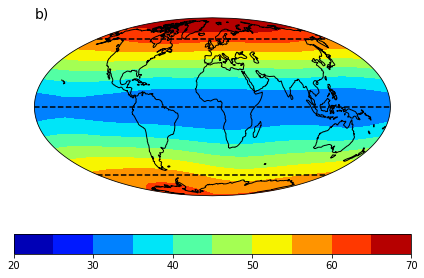

In [9]:
# same as for Figure 1a but using holocene averaged field table (holo_mod.txt)
Ds,Is,Bs,Brs,lons,lats=pmag.do_mag_map(0,file='holo_mod.txt',mod='custom')
ax=pmagplotlib.plot_mag_map(1,Bs,lons,lats,'B',cmap=cmap,date='Holocene',proj='Mollweide',contours=False,
                           min=minB,max=maxB)
ax.plot(equator_lons,equator_lats,'k--',transform=ccrs.Geodetic(),markeredgecolor='black')
ax.plot(equator_lons,midN_lats,'k--',transform=ccrs.Geodetic(),markeredgecolor='black')
ax.plot(equator_lons,midS_lats,'k--',transform=ccrs.Geodetic(),markeredgecolor='black')
plt.text(0,1,'b)',transform=ax.transAxes,fontsize=fontsize)
plt.title('')
plt.tight_layout();
#plt.savefig('Figures/field_holocene.svg');

## Last 100 kyr field model
- make the average in the same manner as for the Holocene field
- make the map

In [12]:
ggf100k_taf_mod=ln3_mod[['l','m']]
ggf100k_taf_mod['g']=np.zeros(len(ggf100k_taf_mod))
ggf100k_taf_mod['h']=np.zeros(len(ggf100k_taf_mod))
ggf100k_taf_gh=np.loadtxt('TAF100k_GGF100k',skiprows=1)# from Panovska et al. 2018 ERDA contribution
ggf100k_taf_gh=1e-3*ggf100k_taf_gh.flatten()
k=0
for l in range(1,11):
    for m in range(0,l+1):
        ggf100k_taf_mod.loc[(ggf100k_taf_mod['l']==l)&(ggf100k_taf_mod['m']==m),'g']=ggf100k_taf_gh[k]
        k+=1
        if m==0: 
            ggf100k_taf_mod.loc[(ggf100k_taf_mod['l']==l)&(ggf100k_taf_mod['m']==m),'h']=0
        else:
            ggf100k_taf_mod.loc[(ggf100k_taf_mod['l']==l)&(ggf100k_taf_mod['m']==m),'h']=ggf100k_taf_gh[k]
            k+=1
        
ggf100k_taf_mod.to_csv('ggf100k_taf_mod.txt',sep=' ',index=None,header=False)



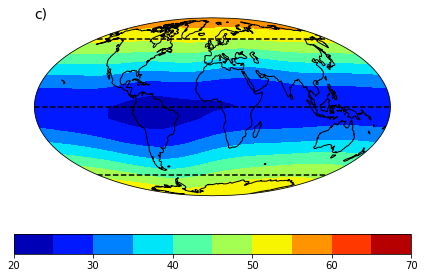

In [13]:
Ds,Is,Bs,Brs,lons,lats=pmag.do_mag_map(0,file='ggf100k_taf_mod.txt',mod='custom')
ax=pmagplotlib.plot_mag_map(1,Bs,lons,lats,'B',cmap=cmap,date='100K',proj='Mollweide',contours=False,
                           min=minB,max=maxB)
ax.plot(equator_lons,equator_lats,'k--',transform=ccrs.Geodetic(),markeredgecolor='black')
ax.plot(equator_lons,midN_lats,'k--',transform=ccrs.Geodetic(),markeredgecolor='black')
ax.plot(equator_lons,midS_lats,'k--',transform=ccrs.Geodetic(),markeredgecolor='black')
plt.text(0,1,'c)',transform=ax.transAxes,fontsize=fontsize)
plt.title('')
plt.tight_layout()



#plt.savefig('Figures/field_100k.svg');

### Last 5 million years
- Use the ln3 model from Cromwell et al. (2018) to make the intensity map.

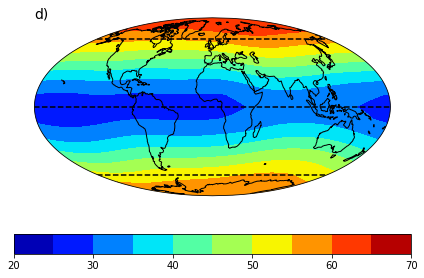

In [14]:
Ds,Is,Bs,Brs,lons,lats=pmag.do_mag_map(0,file='ln3.mm',mod='custom')
ax=pmagplotlib.plot_mag_map(1,Bs,lons,lats,'B',cmap=cmap,date='LN3',proj='Mollweide',contours=False,
                           min=minB,max=maxB)
ax.plot(equator_lons,equator_lats,'k--',transform=ccrs.Geodetic(),markeredgecolor='black')
ax.plot(equator_lons,midN_lats,'k--',transform=ccrs.Geodetic(),markeredgecolor='black')
ax.plot(equator_lons,midS_lats,'k--',transform=ccrs.Geodetic(),markeredgecolor='black')
plt.text(0,1,'d)',transform=ax.transAxes,fontsize=fontsize)
plt.title('')
plt.xlabel('Total field strength ($\mu$T)',fontsize=fontsize)
plt.tight_layout();

#plt.savefig('Figures/field_ln3.svg');

## Figure_2

This section makes the map for figure 2 in the paper.
- set up DataFrames with site names and polygons for plotting
- make the map, which was lightly editted in Adobe Illustrator to clarify site names

Caption from paper: 

A map of the study region. White circles mark sites that were hand sampled for paleointensity. Volcanic units after Weinstein et al. (2006) and Heimann et al., 1996. and this paper. Faults are shown as heavy black lines. 


In [17]:
if True:
    lat_min, lat_max, lon_min, lon_max=32.4,33.3, 35.4,35.9
    clon=.5*(lon_min+lon_max)
    clat=.5*(lat_min+lat_max)
    polys=pd.read_csv('geo_regions.csv',header=0)
    fault_polys=pd.read_csv('faults.csv',header=0)


    periods=polys['period'].unique()
    colors=['green','pink','blue','orange','yellow']
    exclude=['GHI03A','GHI03B','GHI03C','GHI03D','GHI03E','GHI03F','GHI07C']
    sites_df=gh_df[gh_df['site'].isin(exclude)==False]
    site_names=gh_df['site'].values

    periods=['Pleistocene','Late Pliocene', 'Early Pliocene','Miocene', 'Miocene, covered by alluvium']
    new_periods=['Late Pleistocene','Early Middle Pleistocene', 'Early Pliocene','Miocene', 'Miocene, covered by alluvium']


    special=['GHI08','GHI23','GHI24','GHI25','GHI26','GHI27','GHI28',',GHI08','GHI29','GHI31',
            'GHI31','GHI32','GHI33','GHI34','GHI35','GHI36','GHI37','GHI38','GHI39','GHI40',
             'GHI41','GHI42','GHI43','GHI07','GHI48','GHI49','GHI50','GHI44','GHI45','GHI51',
             'GHI52','GHI20','GHI21','GHI22','GHI16','GHI17','GHI18','GHI13','GHI14','GHI15']
    special_exclude=['GHI17','GHI18','GHI24','GHI26','GHI28','GHI29','GHI32','GHI33','GHI34','GHI35',
                     'GHI36','GHI37','GHI38','GHI39','GHI40','GHI41','GHI42','GHI43','GHI48',
                     'GHI50','GHI45','GHI17','GHI18','GHI52','GHI21','GHI22','GHI14','GHI15']


    special_df=sites_df[sites_df['site'].isin(special)]
    special_df=special_df[special_df['site'].isin(special_exclude)==False]
    special_df.loc[special_df['site']=='GHI23','site']='GHI23-24'
    special_df.loc[special_df['site']=='GHI25','site']='GHI25-26'
    special_df.loc[special_df['site']=='GHI27','site']='GHI27-28'
    special_df.loc[special_df['site']=='GHI08','site']='GHI08,GHI29'
    special_df.loc[special_df['site']=='GHI31','site']='GHI31-43'
    special_df.loc[special_df['site']=='GHI16','site']='GHI16-18'
    special_df.loc[special_df['site']=='GHI51','site']='GHI51-52'
    special_df.loc[special_df['site']=='GHI20','site']='GHI20-22'
    special_df.loc[special_df['site']=='GHI13','site']='GHI13-15'
    special_df.loc[special_df['site']=='GHI07','site']='GHI48,GHI07'
    special_df.loc[special_df['site']=='GHI49','site']='GHI49-50'
    special_df.loc[special_df['site']=='GHI44','site']='GHI44-45'
    special_site_names=special_df['site'].unique()

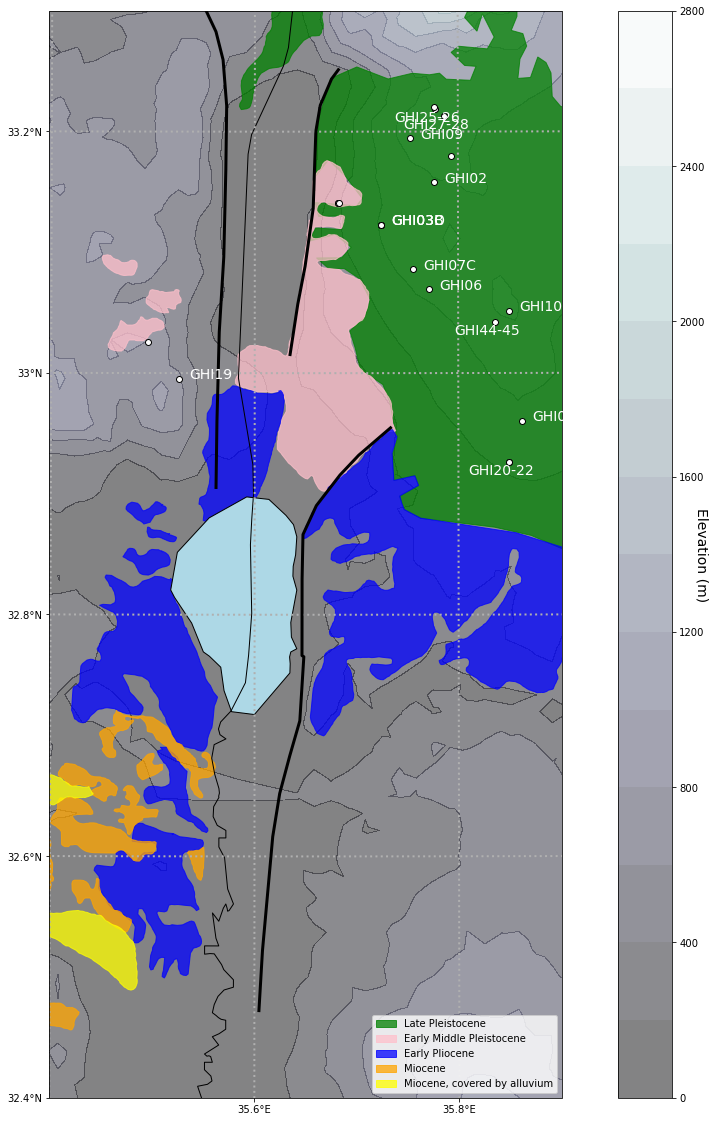

In [18]:
if True:

    proj = ccrs.LambertConformal(central_longitude=clon, central_latitude=clat)
    fig = plt.figure(figsize=(20,20), frameon=True) # you need this frameon to be true
    ax = plt.axes(projection=proj)


    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(LAKES,facecolor='lightblue',edgecolor='black',linewidth=1)
    ax.add_feature(RIVERS,facecolor='lightblue',edgecolor='black',linewidth=1)
    fig.canvas.draw()



    xticks=list(np.arange(lon_min-1,lon_max+2,.2))
    yticks=list(np.arange(lat_min-1,lat_max+1,.2))


    ax.gridlines(ylocs=yticks,xlocs=xticks,linewidth=2, linestyle="dotted")
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) # you need this here
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)# you need this here, too



    lambert_xticks(ax, xticks)
    lambert_yticks(ax, yticks)

    golan_topo=pd.read_csv('golan_elev.txt',delim_whitespace=True,header=None)

    golan_topo.columns=['lon','lat','elev']
    golan_topo=golan_topo[golan_topo['elev']>0]
    levels=range(0,3000,200)
    x=golan_topo.lon.values
    y=golan_topo.lat.values
    z=golan_topo.elev.values
    tcf=ax.tricontourf(x,y,z,transform=ccrs.Geodetic(),cmap='bone',alpha=.5,levels=levels)
    cbar=fig.colorbar(tcf)
    cbar.set_label('Elevation (m)', rotation=270,**text_font)

    for k in range(len(periods)):
        period=periods[k]
        newperiod=new_periods[k]       
        first_leg=True
        poly=polys[polys['period']==period]
        zones=poly['zone'].unique()
        for zone in zones:
            poly_zone=poly[poly['zone']==zone]
            poly_zone=poly_zone[['lon','lat']]
            if period=='Early Pliocene':
                if zone!=2:
                    if first_leg:
                        ax.fill(poly_zone['lon'].values,poly_zone['lat'].values,color=colors[k],
                              transform=ccrs.Geodetic(),alpha=.75,label=newperiod)
                        first_leg=False
                    else:
                        ax.fill(poly_zone['lon'].values,poly_zone['lat'].values,color=colors[k],
                              transform=ccrs.Geodetic(),alpha=.75)


            else:
                if first_leg:
                    ax.fill(poly_zone['lon'].values,poly_zone['lat'].values,color=colors[k],
                            transform=ccrs.Geodetic(),alpha=.75,label=newperiod)
                    first_leg=False
                else:
                    ax.fill(poly_zone['lon'].values,poly_zone['lat'].values,color=colors[k],
                              transform=ccrs.Geodetic(),alpha=.75)

    fault_zones=fault_polys['zone'].unique()
    for fault_zone in fault_zones:
        fault=fault_polys[fault_polys['zone']==fault_zone]
        plt.plot(fault['lon'].values,fault['lat'].values,'k-',transform=ccrs.Geodetic(),linewidth=3)
    galilee_poly=pd.read_csv('galilee.csv')
    galilee_poly.columns=['lon','lat']
    plt.plot(gh_df['lon'].values,gh_df['lat'].values,'wo',transform=ccrs.Geodetic(),
             zorder=2,markeredgecolor='black')
    for site in site_names:
        if site not in special:
            s_df=gh_site_df[gh_site_df['site']==site]
            lon,lat=s_df['lon'].unique()[0],s_df['lat'].unique()[0]
            plt.text(lon+.01,lat,site,transform=ccrs.Geodetic(),color='white',fontsize=fontsize)
    for site in special_site_names:

        s_df=special_df[special_df['site']==site]
        lon,lat=s_df['lon'].unique()[0],s_df['lat'].unique()[0]
        plt.text(lon-.04,lat-.01,site,transform=ccrs.Geodetic(),color='white',fontsize=fontsize)

    ax.legend()

    #plt.savefig(fig_dir+'final_map.pdf');



## Figure_3
- the subplots in this figure was created with the Thellier GUI program of Shaar and Tauxe, 2013 included in the PmagPy software package of Tauxe et al. 2016. 
- they were then edited in Adobe Illustrator for the paper

Caption from paper: 

Examples of  IZZI experiments and the effect of the CCRIT criteria. Circle color indicates the sequence of treatment steps- ZI (blue) or IZ (red). NRM remaining versus  pTRM gained as a function of temperatures (circles). Triangles are pTRM checks. Insets are Zijderveld diagrams for the zero field steps with the magnetization vector  projected onto the xz-plane (red) and the xy-plane (blue) for each specimen. The declinations have been rotated to the `X' axis as these are all unoriented specimens. a) Failed the SCAT criterion because  the 500$^{\circ}$ pTRM step falls outside the SCAT box shown as the blue and red lines.  b) Failed the MAD criterion with MAD of 12.4. c) Failed the Gap Max criterion with G$http_{max}$ of 0.76. d) Failed the curvature criterion with $\vec{k'}$ = 0.728. e) Failed the curvature criterion with $\vec{k'}$ = 0.618. f) Passed all criteria.


## Figure_4
- the subplots in this figure were created by the BiCEP python package available from Cych et al. (2021) and edited with Adobe Illustrator for this paper

Caption: 

Examples of  IZZI experiments and the effect of the BiCEP method. a) Example of 
Arai plot for specimen GHI06A02. Symbols same as in Figure 3. Green lines are Monte Carlo circle fits from the BiCEP method.  b) Plots of intensity estimates from the circle fits against curvature ($\vec{k}$) and Monte Carlo line fits (shown in blue).  c) Density plots of estimated intensities from the y-intercepts of the Monte Carlo line fits to the data shown in b).  The Bayesian 95\% credibility interval on the intensity estimates is 26.5-28.7 $\mu$T.  d) Same as a) but for specimen GHI10B09.  e) same as b) but for site GHI10. f) same as c) but for data shown in e).



## Figure_5

- subplots for this figure were created with the Thellier GUI and BiCEP programs and edited in Adobe Illustrator

Caption: 

Examples BiCEP on a site with specimens that passed CCRIT but failed at the site level for being too scattered (GHI19). a) Data for specimen GHI19C06. Symbols same as in Figure 3.  b) Same as a) but for sister specimen GHI19C08.  c) Estmated intensities for all specimens passing CCRIT from site GHI19. d) Data from GHI19C treated using the BiCEP method.  Symbols same as in Figure 4.


## Figure_6

- make time scale plot for Golan Heights data

Caption:

a) The Geomagnetic Polarity Timescale (Gradstein et al., 2012) for the Pleistocene. b) The VADM estimates and uncertainties from successful sites in this study along with their age constraints. Red (blue) squares (dots) are the CCRIT (BiCEP) site means and 1$\sigma$ uncertainties.  The grey line is  PADM2M  record of Ziegler et al. (2011). The box encloses five sites, three from the GHI03 cinder cone and  GHI25, and GHI26. The average of the GHI03 sites is shown as a star.  The red dashed line is the  average value of the VADMs for the Brunhes Chron (44 ZAm$^2$) and the blue dashed line is that for the period 1-2.5 Ma (63 ZAm$^2$). 
 

Brunhes Mean:  44.137499999999996
Matuyama Mean:  63.41428571428572


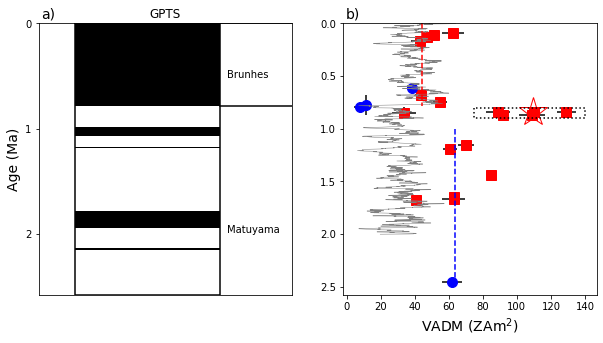

In [19]:
# golan heights- geomagnetic polarity timescale and vadms
ccrit_sites_df=gh_df[gh_df['method_codes'].str.contains('BICEP')==False]
bicep_sites_df=gh_df[gh_df['method_codes'].str.contains('BICEP')]
GHI03=gh_df[gh_df['site'].str.contains('GHI03')]
GHI03_vadm= GHI03['vadm_ZAm2'].mean()
GHI03_vadm_std=GHI03['vadm_ZAm2'].std()
GHI03_int= 1e6*GHI03['int_abs'].mean()
GHI03_std=1e6*GHI03['int_abs'].std()

### do averaging for GHI03:
if averaging:
    ave_sites_df=gh_df[gh_df['site'].str.contains('GHI03B')==False]
    ave_sites_df=ave_sites_df[ave_sites_df['site'].str.contains('GHI03C')==False]
    ave_sites_df.loc[ave_sites_df['site'].str.contains('GHI03D'),'site']='GHI03'
    ave_sites_df.loc[ave_sites_df['site']=='GHI03','int_abs']=GHI03['int_abs'].mean()
    ave_sites_df.loc[ave_sites_df['site']=='GHI03','int_abs_sigma']=GHI03['int_abs'].std()
    ave_sites_df.loc[ave_sites_df['site']=='GHI03','int_abs_sigma_perc']=100*GHI03_std/GHI03_int
    ave_sites_df.loc[ave_sites_df['site']=='GHI03','int_n_specimens']=GHI03['int_n_specimens'].sum()
    ave_sites_df.loc[ave_sites_df['site']=='GHI03','vadm']=GHI03['vadm'].mean()
    ave_sites_df.loc[ave_sites_df['site']=='GHI03','vadm']=GHI03['vadm_sigma'].std()
    ave_sites_df.loc[ave_sites_df['site']=='GHI03','vadm_ZAm2']=GHI03['vadm_ZAm2'].mean()
    ave_sites_df.loc[ave_sites_df['site']=='GHI03','vadm_ZAm2_sigma']=GHI03['vadm_ZAm2'].std()


fig = plt.figure(2, (10, 5))

#Geomagnetic time scale of GTS12
ax=fig.add_subplot(121)
labels = ["Brunhes", "Matuyama", "Gauss", "Gilbert", ""]
bounds = [0,.78, 2.59,3.6,5.33, 10]
ts_plotter.modified_do_TS(ax,0.,age_max, label=labels, labelbounds = bounds )

ax.set_ylim(0,age_max)
ax.invert_yaxis()
ax.set_ylabel("Age (Ma)",**text_font)
ax.text(.01,1.02,'a)',transform=ax.transAxes,**text_font)
plt.title('GPTS')




#Plot VADMs versus age
ax=fig.add_subplot(122)

vadms=gh_df['vadm_ZAm2'].values
ages=gh_df['age'].values
xerrs=gh_df['vadm_ZAm2_sigma'].values
yerrs=gh_df['age_sigma'].values
for k in range(len(vadms)):
    ax.errorbar(vadms[k],ages[k],xerr=xerrs[k],yerr=yerrs[k],ecolor='k')

plt.plot([GHI03_vadm],[0.842],'w*',markeredgecolor='red',markersize=30)
plt.plot(ccrit_sites_df['vadm_ZAm2'], ccrit_sites_df['age'].values, 'rs',markersize=10)
plt.plot(bicep_sites_df['vadm_ZAm2'], bicep_sites_df['age'].values, 'bo',markersize=10)

plt.xlabel("VADM (ZAm$^2$)",**text_font)
plt.ylim(0,age_max)
frame1 = plt.gca()
frame1.axes.set_ylabel("")
ax.invert_yaxis()
ax.text(.01,1.02,'b)',transform=ax.transAxes,**text_font)

plt.plot(padm2m['vadm_ZAm2'],padm2m['age'],color='grey',linewidth=.5)

# calculate brunhes and >1 average
brunhes_df=gh_df[gh_df['age']<=.78]
matuyama_df=gh_df[gh_df['age']>1]

b_mean=brunhes_df['vadm_ZAm2'].mean()
m_mean=matuyama_df['vadm_ZAm2'].mean()

plt.plot([b_mean,b_mean],[0,0.78],'r--')
plt.plot([m_mean,m_mean],[1,2.5],'b--')
plt.plot([75,75,140,140,75],[.8,.9,.9,.8,.8],'k-',linestyle='dotted')
print ('Brunhes Mean: ',b_mean)
print ('Matuyama Mean: ',m_mean)
#plt.savefig(fig_dir+'GPTS.eps')




## Figure_7

- calculate average lat/lon for studies re-analyzed here
- make map of all those plus PINT plus locations of PADM2M studies

Caption: 

Map of site locations from the studies used here.  PINT locations are plotted in grey and the size of the surrounding circles is proportional to the number of sites in each reference.  The locations of the  studies with measurement level data available that passed the CCRIT/BiCEP criteria are plotted as  stars (Northern Israel: red; Antartica: blue; Iceland: green, HSDP2: cyan). Plus signs are locations of cores included in PADM2M Ziegler et al. (2011).

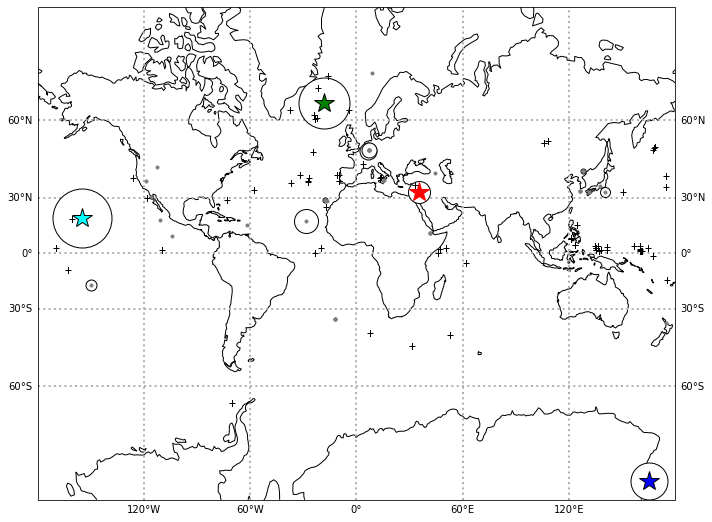

In [20]:
ant_lon,ant_lat=ant_df['lon'].mean(),ant_df['lat'].mean()
ice_lon,ice_lat=ice_df['lon'].mean()-360,ice_df['lat'].mean()
haw_lon,haw_lat=haw_df['lon'].mean()-360,haw_df['lat'].mean()


refs=pint_df['citations'].unique()
fig=plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.Mercator(
    central_longitude=0, min_latitude=-80.0, max_latitude=80.0, globe=None))
ylabels=np.arange(-90,91,30)
xlabels=np.arange(-180.,181,60.)
g1=ax.gridlines(xlocs=xlabels,ylocs=ylabels, crs=ccrs.PlateCarree(),
                linewidth=2,linestyle='dotted',draw_labels=False)
xlabels=np.arange(-180.,180,60.)
glabels = ax.gridlines(xlocs=xlabels,
                       ylocs=ylabels,
                       draw_labels=True, alpha=0)
glabels.xlabels_top = False
for ref in refs:
    ref_df=pint_df[pint_df['citations']==ref]
    lat,lon=ref_df['lat'].mean(),ref_df['lon'].mean()
    size=len(ref_df)
    ax.plot([lon],[lat],marker='o',color='white',\
        markersize=size,transform=ccrs.Geodetic(),markeredgecolor='black')
    ax.plot([lon],[lat],marker='.',color='grey',\
        transform=ccrs.Geodetic())
ax.plot([35.6],[32.8],marker='o',color='white',markersize=len(gh_df),transform=ccrs.Geodetic(),
          markeredgecolor='black')
ax.plot([ice_lon],[ice_lat],marker='o',color='white',markersize=len(ice_df),transform=ccrs.Geodetic(),
          markeredgecolor='black')


ax.plot([ant_lon],[ant_lat],marker='o',color='white',markersize=len(ant_df),transform=ccrs.Geodetic(),
          markeredgecolor='black')
ax.plot([haw_lon],[haw_lat],marker='o',color='white',markersize=len(haw_df),transform=ccrs.Geodetic(),
          markeredgecolor='black')



ax.plot([35.6],[32.8],marker='*',color='red',markersize=20,transform=ccrs.Geodetic())

ax.plot([ice_lon],[ice_lat],marker='*',color='green',markersize=20,transform=ccrs.Geodetic(),markeredgecolor='black')
ax.plot([ant_lon],[ant_lat],marker='*',color='blue',markersize=20,transform=ccrs.Geodetic(),markeredgecolor='black')
ax.plot([haw_lon],[haw_lat],marker='*',color='cyan',markersize=20,transform=ccrs.Geodetic(),markeredgecolor='black')

padm_input_dir='PADM2M_RPI_Datafiles/'
padm_files=os.listdir(padm_input_dir)

plats,plons=[],[]
for file in padm_files:
    if 'llap' in file:
        d=np.loadtxt(padm_input_dir+file)
        plat=d[0][0]
        plon=d[0][1]
        ax.plot(plon,plat,marker='+',color='black',transform=ccrs.Geodetic())

ax.coastlines()

ax.set_global() # we need this or weird things happen

ax.set_ylabel('Latitude $^{\circ}$')
ax.set_xlabel('Longitude $^{\circ}$')
plt.tight_layout();
#plt.savefig(fig_dir+'filteredPintMap.pdf')





## Figure_8

- a) make a plot of newly re-interpreted data sets as a function of latitude
- b) make a plot of PINT, with re-interpreted data replaced

Caption: 

a) VADM estimates from four similar studies: Asefaw et al. (2021) (blue circles),
this study (red squares), Cromwell et al. (2015b) (green diamonds) and Cai et al. (2017); Tauxe
and Love (2003) (HSDP2 combined: cyan triangles). Only Pleistocene sites that passed our
CCRIT set of selection criteria or BiCEP are included. The stars mark the average VADM in
each study. Error bars are one standard deviation. Dotted line is the grand mean of the four
locations. b) Filtered data from the PINT database of Bono et al. (2022) (black dots). Stars
are averages from 10◦ latitudinal bins along with the standard deviations (black lines). Colored
circles are from a). Data from (Lawrence et al., 2009), (Cromwell et al., 2015b) and HSDP2 from
Cai et al. (2017); Tauxe and Love (2003) are superseded by the Antarctic, Icelandic and HSDP2
data re-analyzed here. They were replaced in the PINT data plotted here.

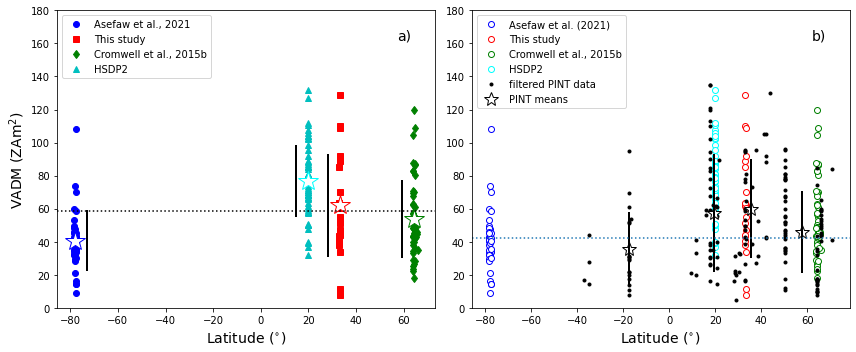

In [21]:
fig=plt.figure(1,figsize=(12,5))
ax1=fig.add_subplot(121)
plt.plot(ant_df['lat'].values,ant_df['vadm_ZAm2'].values,'bo',label='Asefaw et al., 2021')
plt.plot(gh_df['lat'].values,gh_df['vadm_ZAm2'].values,'rs',label='This study')
plt.plot(ice_df['lat'].values,ice_df['vadm_ZAm2'].values,'gd',label='Cromwell et al., 2015b')
plt.plot(haw_df['lat'].values,haw_df['vadm_ZAm2'].values,'c^',label='HSDP2')

plt.plot(ant_df['lat'].values.mean(),ant_df['vadm_ZAm2'].mean(),'w*',markersize=20,markeredgecolor='blue')
plt.plot(gh_df['lat'].values.mean(),gh_df['vadm_ZAm2'].mean(),'w*',markersize=20,markeredgecolor='red')
plt.plot(ice_df['lat'].values.mean(),ice_df['vadm_ZAm2'].mean(),'w*',markersize=20,markeredgecolor='green')

plt.plot(haw_df['lat'].values.mean(),haw_df['vadm_ZAm2'].mean(),'w*',markersize=20,markeredgecolor='cyan')



plt.plot([ant_df['lat'].values.mean()+5,ant_df['lat'].values.mean()+5], 
         [ant_df['vadm_ZAm2'].mean()+ant_df['vadm_ZAm2'].std(),
          ant_df['vadm_ZAm2'].mean()-ant_df['vadm_ZAm2'].std()],'k-',linewidth=2)


plt.plot([ice_df['lat'].values.mean()-5,ice_df['lat'].values.mean()-5], 
         [ice_df['vadm_ZAm2'].mean()+ice_df['vadm_ZAm2'].std(),
          ice_df['vadm_ZAm2'].mean()-ice_df['vadm_ZAm2'].std()],'k-',linewidth=2)


plt.plot([gh_df['lat'].values.mean()-5,gh_df['lat'].values.mean()-5], 
         [gh_df['vadm_ZAm2'].mean()+gh_df['vadm_ZAm2'].std(),
          gh_df['vadm_ZAm2'].mean()-gh_df['vadm_ZAm2'].std()],'k-',linewidth=2)

plt.plot([haw_df['lat'].values.mean()-5,haw_df['lat'].values.mean()-5], 
         [haw_df['vadm_ZAm2'].mean()+haw_df['vadm_ZAm2'].std(),
          haw_df['vadm_ZAm2'].mean()-haw_df['vadm_ZAm2'].std()],'k-',linewidth=2)




ax1.set_ylim (0,180)

ax1.set_xlabel('Latitude ($^{\circ}$)',fontsize=fontsize)
ax1.set_ylabel('VADM (ZAm$^2$)',fontsize=fontsize)
grand_mean=(gh_df['vadm_ZAm2'].mean()+ant_df['vadm_ZAm2'].mean()+ice_df['vadm_ZAm2'].mean()
           +haw_df['vadm_ZAm2'].mean())/4
plt.axhline(grand_mean,linestyle='dotted',color='black')

plt.legend(loc='upper left')
plt.text(.9,.9,'a)',transform=ax1.transAxes,**text_font)


if True: 
    ax2=fig.add_subplot(122)
    
    plt.plot(ant_df['lat'].values,ant_df['vadm_ZAm2'].values,'wo',markeredgecolor='blue',label='Asefaw et al. (2021)')
    plt.plot(gh_df['lat'].values,gh_df['vadm_ZAm2'].values,'wo',markeredgecolor='red',label='This study')
    plt.plot(ice_df['lat'].values,ice_df['vadm_ZAm2'].values,'wo',markeredgecolor='green',label='Cromwell et al., 2015b')
    plt.plot(haw_df['lat'].values,haw_df['vadm_ZAm2'].values,'wo',markeredgecolor='cyan',label='HSDP2')



    lat_bins,vadm_bins,sigmas_bins=[],[],[]
    for lat in range(-80,90,20):
        bin_df=pint_df[(pint_df['lat']>=lat-10)&(pint_df['lat']<=lat+10)]
        if len(bin_df)>10: # need 10 sites for good average
            lat_bins.append(bin_df['lat'].mean())
            vadm_bins.append(bin_df['vadm_ZAm2'].mean())
            sigmas_bins.append(bin_df['vadm_ZAm2'].std())
    bin_df=pd.DataFrame()
    bin_df['lat']=lat_bins
    bin_df['vadm']=vadm_bins
    bin_df['sigmas']=sigmas_bins
    plt.plot(pint_df['lat'],pint_df['vadm_ZAm2'],'k.',label='filtered PINT data')


    plt.plot(bin_df['lat'],bin_df['vadm'],'w*',markersize=15,markeredgecolor='black',label='PINT means')

    for lat in lat_bins:
        df=bin_df[bin_df['lat']==lat]
        plt.plot([df['lat'],df['lat']], 
             [df['vadm']+df['sigmas'],df['vadm']-df['sigmas']],'k-',linewidth=2)





    plt.legend(loc='upper left')
    ax2.set_ylim (0,180)
    ax2.set_xlabel('Latitude ($^{\circ}$)',fontsize=fontsize)

    plt.axhline(42,linestyle='dotted',label='Long term average')

    plt.text(.9,.9,'b)',transform=ax2.transAxes,**text_font)

    plt.tight_layout()
#plt.savefig(fig_dir+'collaborators.eps');



## Figure_9
- plot cumulative distribution functions for the data (re-)analyzed here.
- plot CDFs from the PINT studies used here. 

Caption:

Cumulative distribution functions of VADMs from Pleistocene paleointensity data.
a) Data sets (re-)analyzed here. Red line: Northern Israel (this study), Blue line: Antarctica
(Asefaw et al., 2021); Green line: Iceland (Cromwell et al., 2015b); Cyan line HSDP2 (Cai et
al., 2017; Tauxe & Love, 2003). b) Data from the PINT database and PADM2M (Ziegler et al.,
2011) (grey line). Data in PINT from Antarctica (Lawrence et al., 2009), from HSDP2 (Cai et
al., 2017; Tauxe & Love, 2003), and from Iceland (Cromwell et al., 2015b) were replaced with the
re-analyzed data from this study. Red line: mid-latitude data (30-60◦N), green line: high-latitude
data (≥ 60◦N); cyan line: low latitude northern hemisphere data (0-30◦N), blue line: data from
southern hemisphere (latitudes < 0◦N). Stars are median values for each subset of the data.

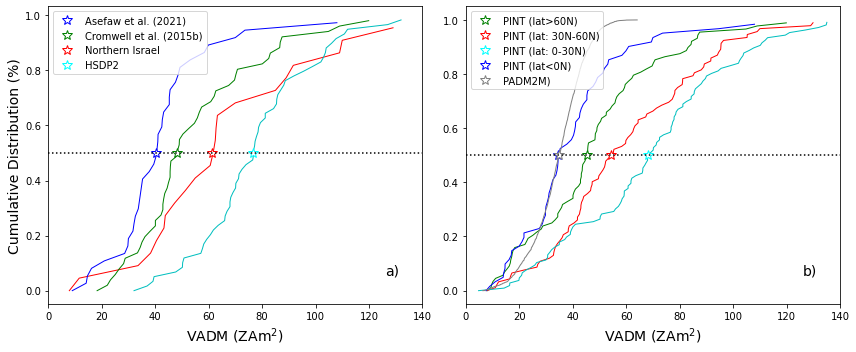

In [22]:
mid_lat=new_pint[(new_pint['lat']>30)&(new_pint['lat']<60)]
high_lat=new_pint[new_pint['lat']>60]
low_lat=new_pint[(new_pint['lat']>0)&(new_pint['lat']<30)]
south_lat=new_pint[new_pint['lat']<0]



padm2m_cdf=padm2m.sort_values(by='vadm_ZAm2')
fig=plt.figure(1,figsize=(12,5))
markersize=10
ax1=fig.add_subplot(121)

gh_df.sort_values(by='vadm_ZAm2',inplace=True)
ant_df.sort_values(by='vadm_ZAm2',inplace=True)
ice_df.sort_values(by='vadm_ZAm2',inplace=True)
haw_df.sort_values(by='vadm_ZAm2',inplace=True)

#(gh_df['vadm_ZAm2'].values,color='cyan',label='This study')
x,y=pmagplotlib.plot_cdf(1,gh_df['vadm_ZAm2'].values,'','r-',"")

x,y=pmagplotlib.plot_cdf(1,ant_df['vadm_ZAm2'].values,'','b-',"")
x,y=pmagplotlib.plot_cdf(1,ice_df['vadm_ZAm2'].values,'','g-',"")
x,y=pmagplotlib.plot_cdf(1,haw_df['vadm_ZAm2'].values,'','c-',"")
gh_med=gh_df['vadm_ZAm2'].median()
ant_med=ant_df['vadm_ZAm2'].median()
ice_med=ice_df['vadm_ZAm2'].median()
haw_med=haw_df['vadm_ZAm2'].median()
plt.plot([ant_med],[0.5],'w*',markeredgecolor='blue',label='Asefaw et al. (2021)',markersize=markersize)
plt.plot([ice_med],[0.5],'w*',markeredgecolor='green',label='Cromwell et al. (2015b)',markersize=markersize)
plt.plot([gh_med],[0.5],'w*',markeredgecolor='red',label='Northern Israel',markersize=markersize)
plt.plot([haw_med],[0.5],'w*',markeredgecolor='cyan',label='HSDP2',markersize=markersize)





ax1.set_xlabel("VADM (ZAm$^2$)",fontsize=fontsize)
ax1.set_ylabel("Cumulative Distribution (%)",fontsize=fontsize)
plt.axhline(0.5,color='black',linestyle='dotted')
ax1.legend(loc='upper left')
plt.text(.9,.1,'a)',transform=ax1.transAxes,**text_font)
ax1.set_xlim(0,140)

ax2=fig.add_subplot(122)

high_lat.sort_values(by='vadm_ZAm2',inplace=True)
mid_lat.sort_values(by='vadm_ZAm2',inplace=True)
low_lat.sort_values(by='vadm_ZAm2',inplace=True)
south_lat.sort_values(by='vadm_ZAm2',inplace=True)
#(gh_df['vadm_ZAm2'].values,color='cyan',label='This study')
x,y=pmagplotlib.plot_cdf(1,high_lat['vadm_ZAm2'].values,'','g-','')

x,y=pmagplotlib.plot_cdf(1,mid_lat['vadm_ZAm2'].values,'','r-',"")
#x,y=pmagplotlib.plot_cdf(1,gh_df['vadm_ZAm2'].values,'','r-',"",linewidth=2)
x,y=pmagplotlib.plot_cdf(1,low_lat['vadm_ZAm2'].values,'','c-',"")
x,y=pmagplotlib.plot_cdf(1,south_lat['vadm_ZAm2'].values,'','b-',"")
x,y=pmagplotlib.plot_cdf(1,padm2m_cdf['vadm_ZAm2'].values,'','y-',"",color='grey')



high_med=high_lat['vadm_ZAm2'].median()
mid_med=mid_lat['vadm_ZAm2'].median()
low_med=low_lat['vadm_ZAm2'].median()
south_med=south_lat['vadm_ZAm2'].median()
padm2m_med=padm2m['vadm_ZAm2'].median()

#plt.plot([gh_med+2],[0.5],'r*',label='Northern Israel',markersize=markersize)
plt.plot([high_med],[0.5],'w*',markeredgecolor='green',label='PINT (lat>60N)',markersize=markersize)
plt.plot([mid_med],[0.5],'w*',markeredgecolor='red',label='PINT (lat: 30N-60N)',markersize=markersize)
plt.plot([low_med],[0.5],'w*',markeredgecolor='cyan',label='PINT (lat: 0-30N)',markersize=markersize)
plt.plot([south_med],[0.5],'w*',markeredgecolor='blue',label='PINT (lat<0N)',markersize=markersize)
plt.plot([padm2m_med],[0.5],'w*',markeredgecolor='grey',label='PADM2M)',markersize=markersize)




ax2.set_xlabel("VADM (ZAm$^2$)",fontsize=fontsize)
ax2.set_ylabel("")
#plt.ylabel("Cumulative Distribution (%)",fontsize=fontsize)
plt.axhline(0.5,color='black',linestyle='dotted')
ax2.legend(loc='upper left')
plt.text(.9,.1,'b)',transform=ax2.transAxes,**text_font)


ax2.set_xlim(0,140)

plt.tight_layout();
#plt.savefig(fig_dir+'CDFs.eps')




## Figure_10

- VADM for re-interpreted data versus age

Caption: 

VADM estimates for Pleistocene aged data from the studies re-analyzed here
along with the globally averaged estimates from PADM2M of Ziegler et al. (2011) (gray line). All
absolute paleointensity studies performed an IZZI-modified Thellier-Thellier experiment and were
re-interpreted with a uniform set of selection criteria to estimate paleointensity. Paleointensities
were recovered from 42 sites (blue circles) from Antarctica (Asefaw et al., 2021), 22 sites (red
squares) from Northern Israel, 51 sites (green diamonds) from Iceland (Cromwell et al., 2015b)
and 59 sites from HSDP2 (Cai et al., 2017; Tauxe & Love, 2003). Only data from sites with age
uncertainties <0.2 are shown.

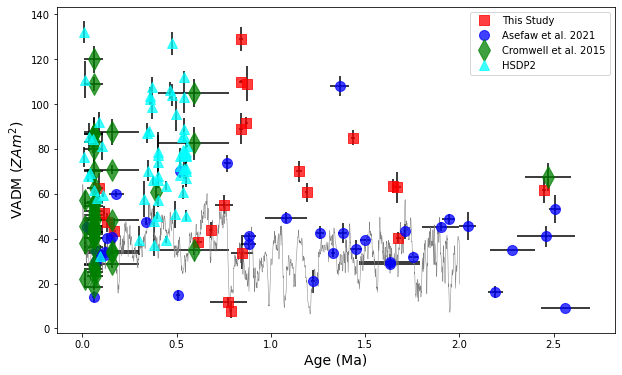

In [23]:
# vadm vs. age (re-interpreted data)
ice=ice_df[ice_df['age_sigma']<.2]
ant=ant_df[ant_df['age_sigma']<.2]
gh=gh_df[gh_df['age_sigma']<.2]

plt.figure(1, (10,6))
plt.plot(padm2m['age'],padm2m['vadm_ZAm2'],color='grey',linewidth=.5)

plt.plot( gh['age'], gh['vadm_ZAm2'],"rs", label = "This Study",markersize=markersize,
        alpha=.75)
for i in range(gh['vadm_ZAm2'].size):
    plt.errorbar(gh['age'].values[i],gh['vadm_ZAm2'].values[i], 
                 xerr = gh['age_sigma'].values[i], yerr = gh['vadm_ZAm2_sigma'].values[i], color="k")
    


    
plt.plot(ant['age'],ant['vadm_ZAm2'], "o" , label = "Asefaw et al. 2021",markersize=markersize,
        color='blue',alpha=.75)
for i in range(ant['age'].size):
    plt.errorbar(ant['age'].values[i],ant['vadm_ZAm2'].values[i], 
                 xerr = ant['age_sigma'].values[i], yerr = ant['vadm_ZAm2_sigma'].values[i], color="k")
    

plt.plot( ice['age'], ice['vadm_ZAm2'],"d", label = "Cromwell et al. 2015",markersize=1.5*markersize,
        color='green',alpha=.75)
for i in range(ice['vadm_ZAm2'].size):
    plt.errorbar(ice['age'].values[i],ice['vadm_ZAm2'].values[i], 
                 xerr = ice['age_sigma'].values[i], yerr = ice['vadm_ZAm2_sigma'].values[i], color="k")

plt.plot( haw_df['age'], haw_df['vadm_ZAm2'],"^", label = "HSDP2",markersize=markersize,
        color='cyan',alpha=.75)

for i in range(haw_df['vadm_ZAm2'].size):
    plt.errorbar(haw_df['age'].values[i],haw_df['vadm_ZAm2'].values[i], 
                 yerr = haw_df['vadm_ZAm2_sigma'].values[i], color="k")
plt.ylabel("VADM ($ZAm^2$)",**text_font)
plt.xlabel("Age (Ma)",**text_font)

plt.legend();
#plt.savefig(fig_dir+'comparisonVADM.pdf');

## Figure_S1
- $^{40}$Ar/$^{39}$Ar age spectra of 26 sites dated in this study. 

Caption: 

40Ar/39Ar age spectra of 26 sites dated in this study. Site ages were determined
based on the plateau age or in two cases a mini-plateau (GHI30 and GHI44), see Table 1.)


# of new ages:  26


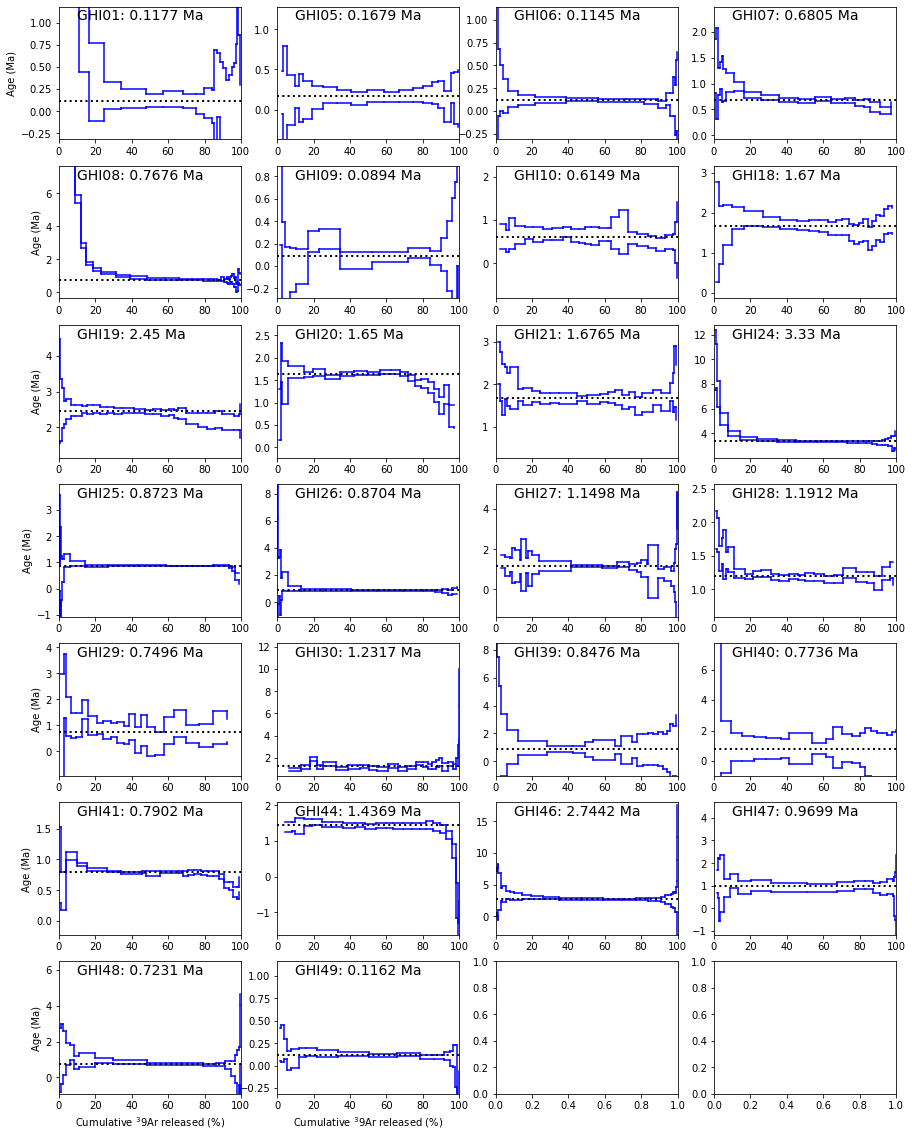

In [24]:
nrows,ncols=7,4
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,20))
meta=pd.read_csv(dir_path+'/ages.txt',sep='\t',header=1)
meta.dropna(subset=['description'],inplace=True)
sites=meta['site'].values
print ('# of new ages: ',len(sites))
row,col=0,0
#sites=['GHI01']
special=['GHI18','GHI20','GHI24']# these are in units of Ma, not ka
for site in sites:
    if col>=ncols:
        row+=1
        col=0
    exp_meta=meta[meta['site']==site]
    exp_num=exp_meta['description'].values[0]
    age=str(round(exp_meta['age'].values[0],4))
    file=exp_num+'.full.xls'
    ax=axs[row,col]
    if site in special:
        sum_df=get_arar(ax,file,site,age,age_unit='Ma')
    else:
        sum_df=get_arar(ax,file,site,age,age_unit='ka')
        if row==nrows-1:
            ax.set_xlabel('Cumulative $^39$Ar released (%)')
        if col==0:
            ax.set_ylabel('Age (Ma)')
    col+=1

#plt.savefig(fig_dir+'Ar-ar.pdf')   

